In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

os.environ["CUDA_VISIBLE_DEVICES"]="0"



In [2]:

BaseDir = '/run/media/sancere/DATA1/Lucas_NextonCreated_npz/'
ModelName = 'Training_CARE_restoration_SpinwideFRAP4_Bin2_Reduced'


load_path = BaseDir + ModelName + '.npz'

(X,Y), (X_val,Y_val), axes = load_training_data(load_path, validation_split=0.1, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 70330
number of validation images:	 7814
image size (3D):		 (16, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


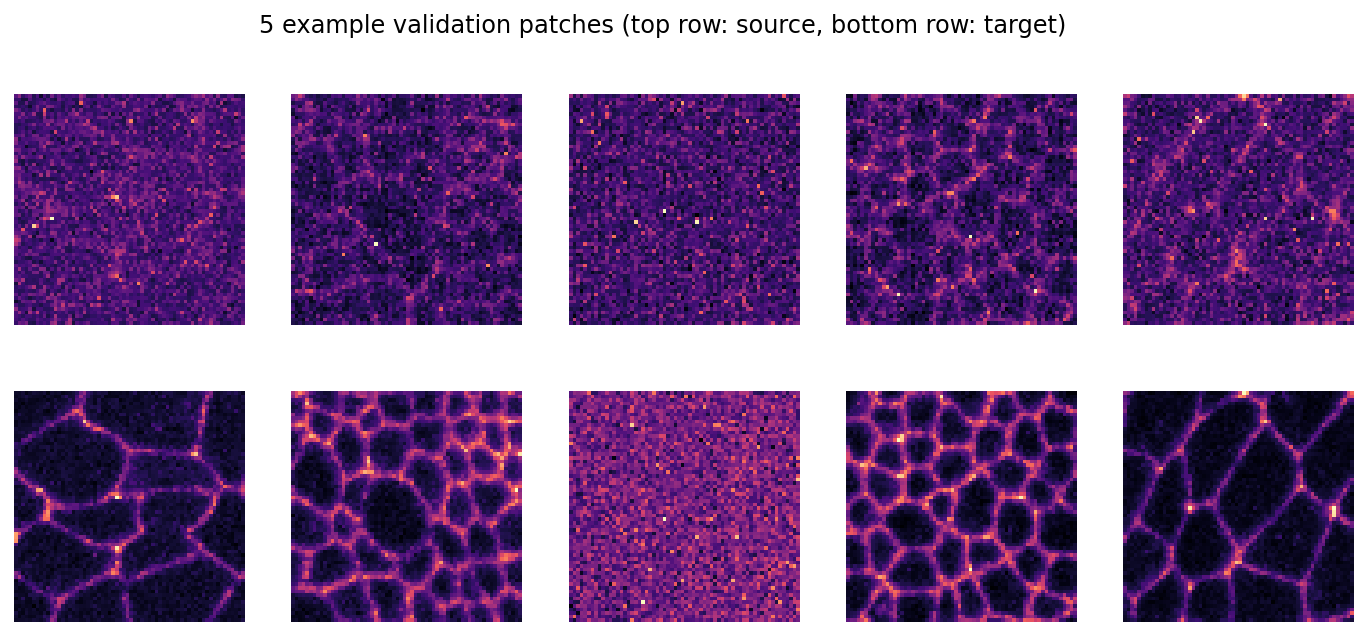

In [3]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [4]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=4,train_epochs= 100,train_steps_per_epoch = 100, train_batch_size = 16, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

#To see correct hyperparameters look at .py file!!!!!

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 5, 'factor': 0.5}, train_steps_per_epoch=100, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=4, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 4,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'patience': 5, 'factor': 0.5}}

In [5]:
model = CARE(config = config, name = ModelName, basedir = BaseDir)
#model.load_weights(BaseDir + ModelName + '/weights_best.h5')

In [6]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
100/100 [==============================] - 62s 618ms/step - loss: 0.1177 - mse: 0.0272 - mae: 0.1177 - val_loss: 0.0871 - val_mse: 0.0148 - val_mae: 0.0871 - lr: 4.0000e-04
Epoch 2/100
100/100 [==============================] - 62s 624ms/step - loss: 0.0759 - mse: 0.0131 - mae: 0.0759 - val_loss: 0.0732 - val_mse: 0.0130 - val_mae: 0.0732 - lr: 4.0000e-04
Epoch 3/100
100/100 [==============================] - 62s 615ms/step - loss: 0.0729 - mse: 0.0125 - mae: 0.0729 - val_loss: 0.0735 - val_mse: 0.0116 - val_mae: 0.0735 - lr: 4.0000e-04
Epoch 4/100
100/100 [==============================] - 63s 630ms/step - loss: 0.0708 - mse: 0.0114 - mae: 0.0708 - val_loss: 0.0681 - val_mse: 0.0108 - val_mae: 0.0681 - lr: 4.0000e-04
Epoch 5/100
100/100 [==============================] - 64s 638ms/step - loss: 0.0662 - mse: 0.0095 - mae: 0.0662 - val_loss: 0.0680 - val_mse: 0.0109 - val_mae: 0.0680 - lr: 4.0000e-04
Epoch 6/100
100/100 [==============================] - 64s 635ms/step - los

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


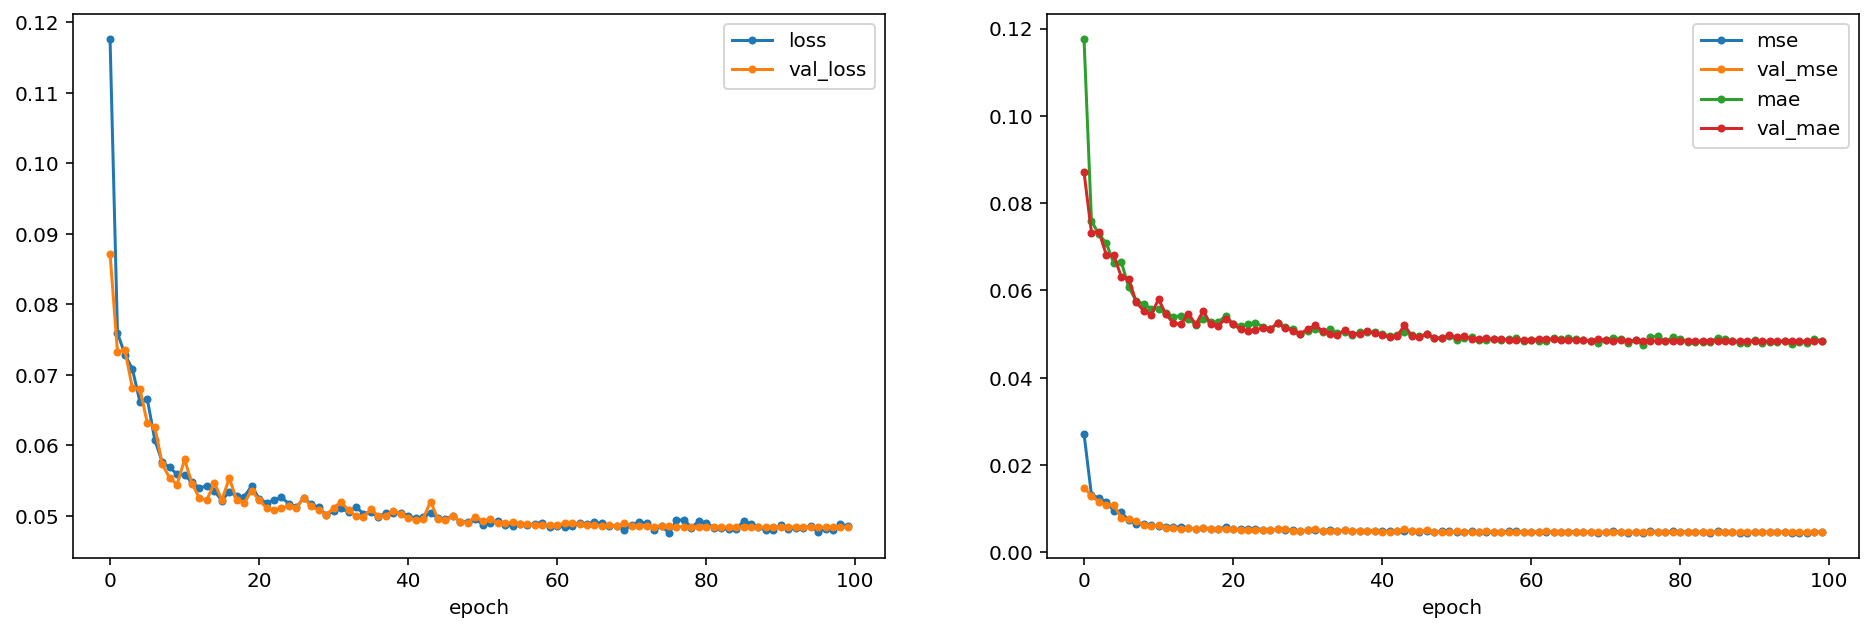

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

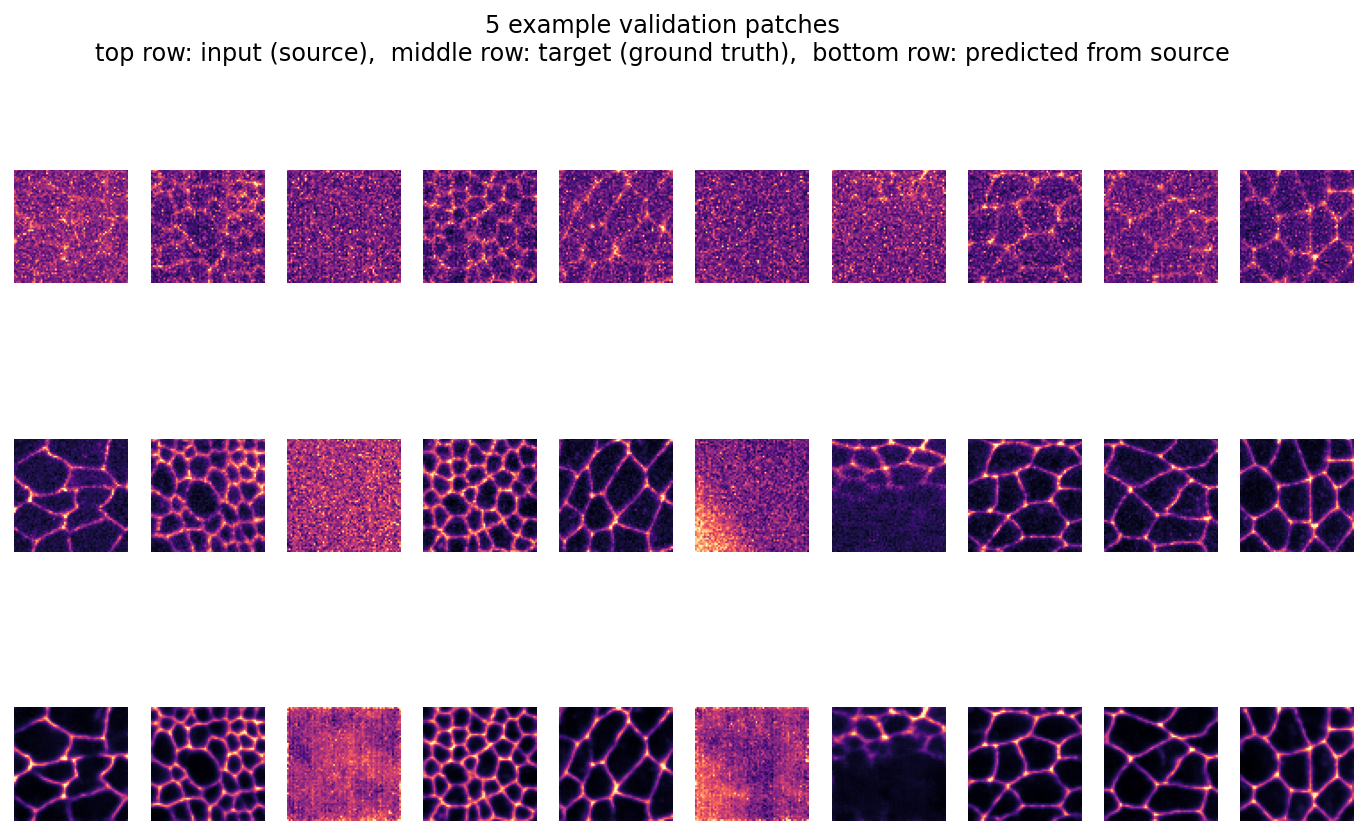

In [8]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:10])
if config.probabilistic:
     _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:10],Y_val[:10],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
              'top row: input (source),  '          
              'middle row: target (ground truth),  '
              'bottom row: predicted from source');

In [9]:
model.export_TF()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpn8ruzit5/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/run/media/sancere/DATA1/Lucas_NextonCreated_npz/Training_CARE_restoration_SpinwideFRAP4_Bin2_Reduced/TF_SavedModel.zip


In [10]:
from csbdeep.utils import Path

TriggerName = '/home/sancere/NextonDisk_1/TimeTrigger/TT3'
Path(TriggerName).mkdir(exist_ok = True)